In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import time
import os
from joblib import Memory
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')
Base_Path = "/content/drive/MyDrive/capstone_project_fire_risk"

Mounted at /content/drive


In [3]:
uef_df = gpd.read_file(f"{Base_Path}/property_assessment_cleaned/property_assessment_cleaned.shp", driver='ESRI Shapefile')


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DRIVER
  return ogr_read(


In [74]:
def lower_case_dataframe(df):
  """Lower cases all string columns in a Pandas DataFrame.

  Args:
    df: The input DataFrame.

  Returns:
    A new DataFrame with string columns lowercased.
    Returns the original DataFrame if no string columns are found.
  """

  # Find string columns
  string_cols = df.select_dtypes(include=['object']).columns

  if not string_cols.empty:
    # Create a copy to avoid modifying the original DataFrame
    df_lower = df.copy()

    # Apply lowercasing to each string column
    for col in string_cols:
      df_lower[col] = df_lower[col].str.lower()

    return df_lower
  else:
    return df # Return original if no string columns



In [4]:
# Define the variables for the different columns
UEV_ID = 'UEV_ID'
CIVIC_START = 'CVC_START'
CIVIC_END = 'CVC_END'
STREET_NAME = 'STR_NAME'
UNIT_NUMBER_START = 'UNIT_START'
FLOORS_ABOVE_GROUND = 'FLRS_AGND'
NUMBER_OF_UNITS = 'NBR_UNITS'
CONSTRUCTION_YEAR = 'CONS_YEAR'
USE_CODE = 'USE_CODE'
LAND_START = 'L_START'
LAND_END = 'L_END'
USE_DESCRIPTION = 'USE_DES'
UEF_CATEGORY = 'UEF_CAT'
LAND_ROLL_NUMBER = 'LR_NBR'
LAND_AREA = 'LAND_A'
BUILDING_AREA = 'BLD_AREA'
BUILDING_AGE = 'BLD_AGE'
DISTRICT_ID = 'DIST_ID'
MUNICIPALITY_CODE = 'MUNI_CODE'
MUNICIPALITY_NAME = 'MUNI_NAME'
USE_CATEGORY = 'USE_CAT'
GEOMETRY = 'geometry'
AGE_GROUP = 'AGE_GR'
CENTROID = 'centroid'

In [5]:
uef_df.describe()

,MUNI_CODE,FLRS_AGND,NBR_UNITS,USE_CODE,CONS_YEAR,BLD_AGE,BLD_AREA
count,349274.000000,349274.000000,349274.000000,349274.000000,349274.000000,349274.000000,346691.000000
mean,43.019586,1.814885,2.420796,1185.501683,1959.629457,65.370543,364.054841
std,15.374661,0.936059,9.040810,902.870639,29.975379,29.975379,2420.139964
min,2.000000,-1.000000,-1.000000,1000.000000,1680.000000,1.000000,0.000000
25%,50.000000,1.000000,1.000000,1000.000000,1947.000000,44.000000,124.000000
50%,50.000000,2.000000,1.000000,1000.000000,1960.000000,65.000000,187.000000
75%,50.000000,2.000000,2.000000,1000.000000,1981.000000,78.000000,256.000000
max,50.000000,41.000000,1351.000000,9520.000000,2024.000000,345.000000,947140.000000


In [7]:
# Calculate the number of buildings with age greater than 345
num_buildings_old = len(uef_df[uef_df[BUILDING_AGE] > 345])

print(f"The number of buildings with age superior than 345 is: {num_buildings_old}")


The number of buildings with age superior than 345 is: 0


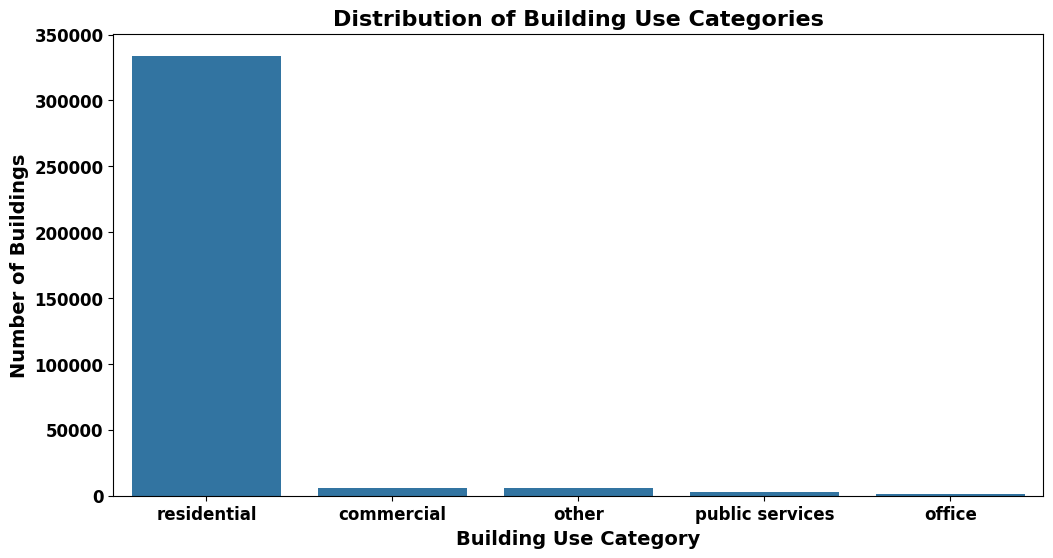

USE_CAT
residential        333931
commercial           5798
other                5640
public services      2882
office               1023
Name: count, dtype: int64


In [21]:
# Analyze the distribution of building use category
plt.figure(figsize=(12, 6))
sns.countplot(x=USE_CATEGORY, data=uef_df, order=uef_df[USE_CATEGORY].value_counts().index) # Order bars by frequency
plt.title('Distribution of Building Use Categories', fontsize=16, fontweight='bold')
plt.ylabel('Number of Buildings', fontsize=14, fontweight='bold')
plt.xlabel('Building Use Category', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

print(uef_df[USE_CATEGORY].value_counts())


In [21]:
uef_df.columns

Index(['UEV_ID', 'CIVIC_START', 'CIVIC_END', 'STREET_NAME',
       'UNIT_NUMBER_START', 'MUNICIPALITY_CODE', 'FLOORS_ABOVE_GROUND',
       'NUMBER_OF_UNITS', 'CONSTRUCTION_YEAR', 'USE_CODE', 'LETTER_START',
       'LETTER_END', 'USE_DESCRIPTION', 'UEF_CATEGORY', 'LAND_ROLL_NUMBER',
       'LAND_AREA', 'BUILDING_AREA', 'DISTRICT_I', 'MUNICIPALITY_NAME',
       'BUILDING_AGE', 'geometry', 'AgeGroup'],
      dtype='object')

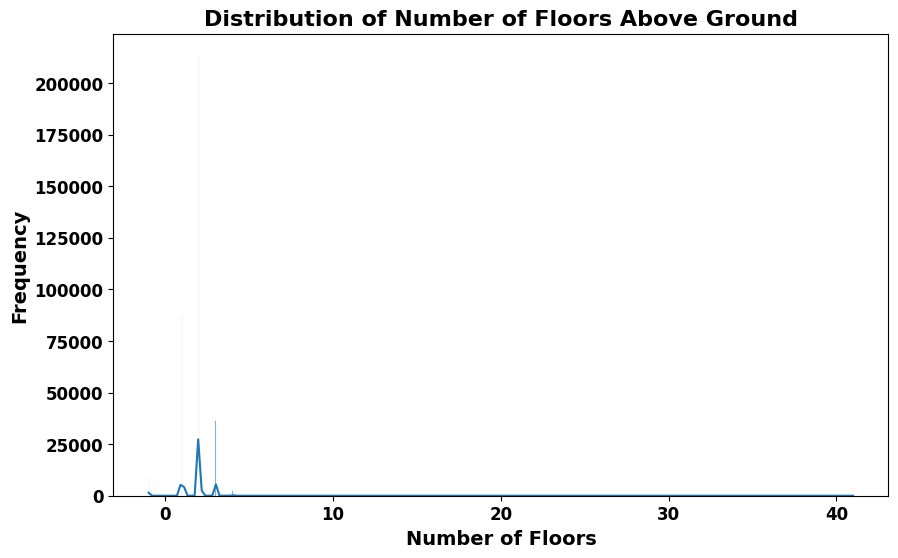

In [22]:
# Analyze the distribution of the number of floors above ground
plt.figure(figsize=(10, 6))
sns.histplot(uef_df['FLOORS_ABOVE_GROUND'], kde=True)  # Use histplot for better visualization
plt.title('Distribution of Number of Floors Above Ground', fontsize=16, fontweight='bold')
plt.xlabel('Number of Floors', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()


In [8]:
uef_df[FLOORS_ABOVE_GROUND].describe()

,FLRS_AGND
count,349274.000000
mean,1.814885
std,0.936059
min,-1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,41.000000


In [24]:
uef_df.head()

,UEV_ID,CIVIC_STAR,CIVIC_END,STREET_NAM,UNIT_NUMBE,MUNICIPALI,FLOORS_ABO,NUMBER_OF_,CONSTRUCTI,USE_CODE,...,LETTER_END,USE_DESCRI,UEF_CATEGO,LAND_ROLL_,LAND_AREA,BUILDING_A,DISTRICT_I,MUNICIPA_1,BUILDING_1,geometry
0,01038405,3577,3577,avenue Atwater,None,50,-1,-1,1983-01-01,1921,...,None,Stationnement intérieur (condo),Condominium,9739-83-9737-8-001-0431,2,NaN,REM19,Montréal,42,"POLYGON ((-73.58918 45.49367, -73.58917 45.493..."
1,05213144,5211,5211,rue du Sureau,105,50,1,1,2012-01-01,1000,...,None,Logement,Condominium,7941-06-3037-4-001-0004,69,68.0,REM31,Montréal,13,"POLYGON ((-73.82985 45.5146, -73.82971 45.5144..."
2,01036349,3550,3550,rue de la Montagne,109,50,3,1,1983-01-01,1000,...,None,Logement,Condominium,9840-31-8010-6-001-0005,133,127.0,REM19,Montréal,42,"POLYGON ((-73.58244 45.5008, -73.58198 45.5011..."
3,05189527,1200,1200,rue Saint-Alexandre,511,50,1,1,1963-01-01,1000,...,None,Logement,Condominium,9940-55-8522-7-001-0257,16,62.0,REM19,Montréal,62,"POLYGON ((-73.56729 45.50468, -73.56717 45.504..."
4,01037334,1254,1254,rue Saint-Marc,61,50,1,1,1914-01-01,1000,...,None,Logement,Condominium,9839-51-6255-9-001-0013,16,82.0,REM19,Montréal,111,"POLYGON ((-73.5799 45.49241, -73.57962 45.4922..."


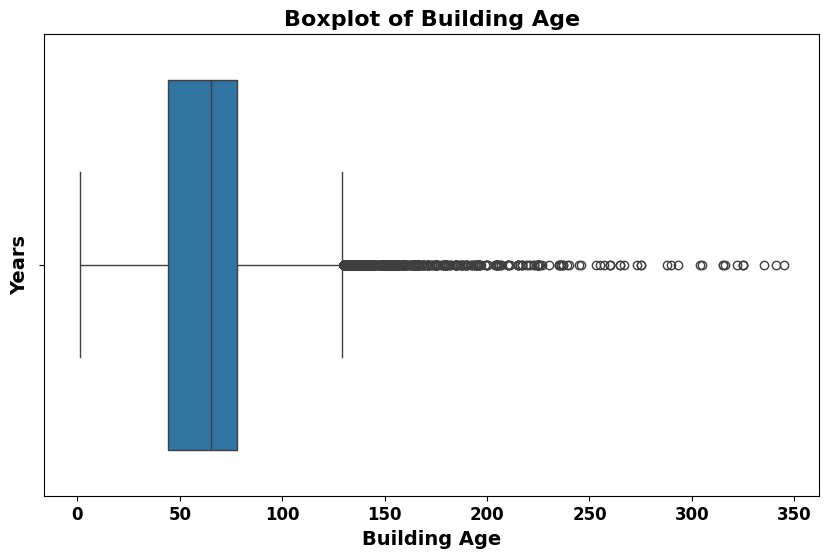

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=BUILDING_AGE, data=uef_df)
plt.title('Boxplot of Building Age', fontsize=16, fontweight='bold')
plt.xlabel('Building Age', fontsize=14, fontweight='bold')
plt.ylabel('Years', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()


In [7]:
# Compute centroid points of polygons
uef_df[CENTROID] = uef_df[GEOMETRY].centroid

# Display the first few rows with the new centroid column
print(uef_df.head())


<ipython-input-7-875dfc5beda5>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  uef_df[CENTROID] = uef_df[GEOMETRY].centroid


     UEV_ID CVC_START             STR_NAME  MUNI_CODE MUNI_NAME DIST_ID  \
0  01038405      3577       avenue atwater         50  montréal   rem19   
1  05213144      5211        rue du sureau         50  montréal   rem31   
2  01036349      3550   rue de la montagne         50  montréal   rem19   
3  05189527      1200  rue saint-alexandre         50  montréal   rem19   
4  01037334      1254       rue saint-marc         50  montréal   rem19   

   FLRS_AGND  NBR_UNITS  USE_CODE                          USE_DES  \
0         -1         -1      1921  stationnement intérieur (condo)   
1          1          1      1000                         logement   
2          3          1      1000                         logement   
3          1          1      1000                         logement   
4          1          1      1000                         logement   

       USE_CAT  CONS_YEAR  BLD_AGE   AGE_GR  BLD_AREA  \
0        other       1983       42    20-50       NaN   
1  residential

In [8]:
# Create a new DataFrame without the geometry column
uef_df_no_geometry = uef_df.drop(columns=['geometry'])

# Display the first few rows of the new DataFrame
print(uef_df_no_geometry.head())


     UEV_ID CVC_START             STR_NAME  MUNI_CODE MUNI_NAME DIST_ID  \
0  01038405      3577       avenue atwater         50  montréal   rem19   
1  05213144      5211        rue du sureau         50  montréal   rem31   
2  01036349      3550   rue de la montagne         50  montréal   rem19   
3  05189527      1200  rue saint-alexandre         50  montréal   rem19   
4  01037334      1254       rue saint-marc         50  montréal   rem19   

   FLRS_AGND  NBR_UNITS  USE_CODE                          USE_DES  \
0         -1         -1      1921  stationnement intérieur (condo)   
1          1          1      1000                         logement   
2          3          1      1000                         logement   
3          1          1      1000                         logement   
4          1          1      1000                         logement   

       USE_CAT  CONS_YEAR  BLD_AGE   AGE_GR  BLD_AREA  \
0        other       1983       42    20-50       NaN   
1  residential

In [9]:
ter_admin_casernes = gpd.read_file(f"{Base_Path}/territoires-administratifs-casernes/territoires-administratifs-casernes.shp")

<Axes: >

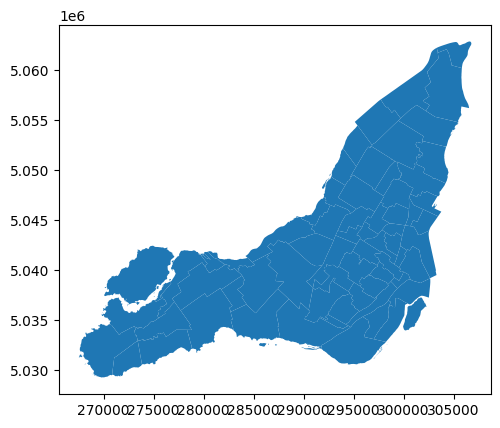

In [57]:
ter_admin_casernes.plot()

In [10]:
ter_admin_casernes.columns

Index(['NOM_CAS_AD', 'NO_CAS_ADM', 'OBJECTID', 'geometry'], dtype='object')

In [11]:
ter_admin_casernes.head()

,NOM_CAS_AD,NO_CAS_ADM,OBJECTID,geometry
0,Caserne 72,72,296,"POLYGON ((287732.12 5042781.704, 287732.125 50..."
1,Caserne 71,71,297,"POLYGON ((286445.616 5041122.006, 286445.662 5..."
2,Caserne 32,32,298,"POLYGON ((306751.569 5062506.945, 306727.987 5..."
3,Caserne 25,25,299,"POLYGON ((298032.411 5041740.83, 298358.761 50..."
4,Caserne 31,31,300,"POLYGON ((296726.745 5043167.591, 296630.684 5..."


In [75]:
# Lower case the dataframe
ter_admin_casernes = lower_case_dataframe(ter_admin_casernes)
ter_admin_casernes.head()

,NOM_CAS_AD,NO_CAS_ADM,OBJECTID,geometry
0,caserne 72,72,296,"POLYGON ((-73.71849 45.52474, -73.71849 45.524..."
1,caserne 71,71,297,"POLYGON ((-73.7349 45.50978, -73.7349 45.50976..."
2,caserne 32,32,298,"POLYGON ((-73.47494 45.70244, -73.47524 45.702..."
3,caserne 25,25,299,"POLYGON ((-73.58662 45.51555, -73.58244 45.513..."
4,caserne 31,31,300,"POLYGON ((-73.60336 45.52838, -73.60459 45.528..."


In [12]:
# @title
"""
from shapely.geometry import Polygon

def create_grid(polygon, grid_size_meters, original_crs):
    """
    Divides a polygon into a grid of squares with the specified size, clipped to the polygon.

    Args:
        polygon: The input polygon (shapely.geometry.Polygon).
        grid_size_meters: The size of the grid cells in meters.
        original_crs: The CRS of the original GeoDataFrame.

    Returns:
        A GeoDataFrame with the grid cells as polygons, clipped to the input polygon.
    """

    # Get polygon bounds
    minx, miny, maxx, maxy = polygon.bounds

    # Create grid points
    x_coords = np.arange(minx, maxx, grid_size_meters)
    y_coords = np.arange(miny, maxy, grid_size_meters)
    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)
    grid_points = gpd.points_from_xy(x_mesh.flatten(), y_mesh.flatten())

    # Create grid polygons
    grid_polygons = []
    for x, y in zip(x_mesh.flatten(), y_mesh.flatten()):
        grid_polygons.append(Polygon([(x, y), (x + grid_size_meters, y),
                                     (x + grid_size_meters, y + grid_size_meters),
                                     (x, y + grid_size_meters)]))

    # Create GeoDataFrame using the original CRS
    grid = gpd.GeoDataFrame({'geometry': grid_polygons}, crs=original_crs)

    # Clip the grid to the input polygon using intersection
    # Ensure both are in the same CRS before this step
    grid = gpd.overlay(grid, gpd.GeoDataFrame({'geometry': [polygon]}, crs=original_crs), how='intersection')

    return grid

"""

In [13]:
ter_admin_casernes.to_crs(epsg=4326)

,NOM_CAS_AD,NO_CAS_ADM,OBJECTID,geometry
0,Caserne 72,72,296,"POLYGON ((-73.71849 45.52474, -73.71849 45.524..."
1,Caserne 71,71,297,"POLYGON ((-73.7349 45.50978, -73.7349 45.50976..."
2,Caserne 32,32,298,"POLYGON ((-73.47494 45.70244, -73.47524 45.702..."
3,Caserne 25,25,299,"POLYGON ((-73.58662 45.51555, -73.58244 45.513..."
4,Caserne 31,31,300,"POLYGON ((-73.60336 45.52838, -73.60459 45.528..."
...,...,...,...,...
61,Caserne 52,52,358,"POLYGON ((-73.89694 45.41273, -73.89698 45.412..."
62,Caserne 63,63,359,"MULTIPOLYGON (((-73.72214 45.48264, -73.71724 ..."
63,Caserne 65,65,360,"MULTIPOLYGON (((-73.60489 45.44842, -73.60495 ..."
64,Caserne 20,20,361,"POLYGON ((-73.54595 45.51965, -73.54507 45.519..."


In [ ]:
# @title
#ter_admin_casernes['geometry'][0]

In [15]:
# @title
#grid = create_grid(ter_admin_casernes['geometry'][0], 1000, ter_admin_casernes.crs)

In [ ]:
# @title
#len(grid)

In [ ]:
# @title
#fig, ax = plt.subplots(figsize=(15, 12))
#grid.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
#plt.show()

In [18]:
# @title
# Assuming 'ter_admin_casernes' is your GeoDataFrame and in a projected CRS (e.g., UTM)
"""
grid_size_km = 0.5  # 1 km grid size
grid_size_meters = grid_size_km * 1000  # Convert km to meters

all_grids = []
for index, row in ter_admin_casernes.iterrows():
    # Pass the CRS of 'ter_admin_casernes' to create_grid
    grid = create_grid(row['geometry'], grid_size_meters, ter_admin_casernes.crs)
    # Assign a unique ID to each grid cell within the administrative area
    grid['grid_id'] = range(len(grid))
    grid['admin_area_id'] = row['NOM_CAS_AD']  # Assuming 'NOM_CAS_AD' is the ID column
    all_grids.append(grid)

# Combine all grids into a single GeoDataFrame
all_grids_gdf = gpd.GeoDataFrame(pd.concat(all_grids, ignore_index=True), crs=ter_admin_casernes.crs)

"""

In [ ]:
# @title
#len(all_grids_gdf)

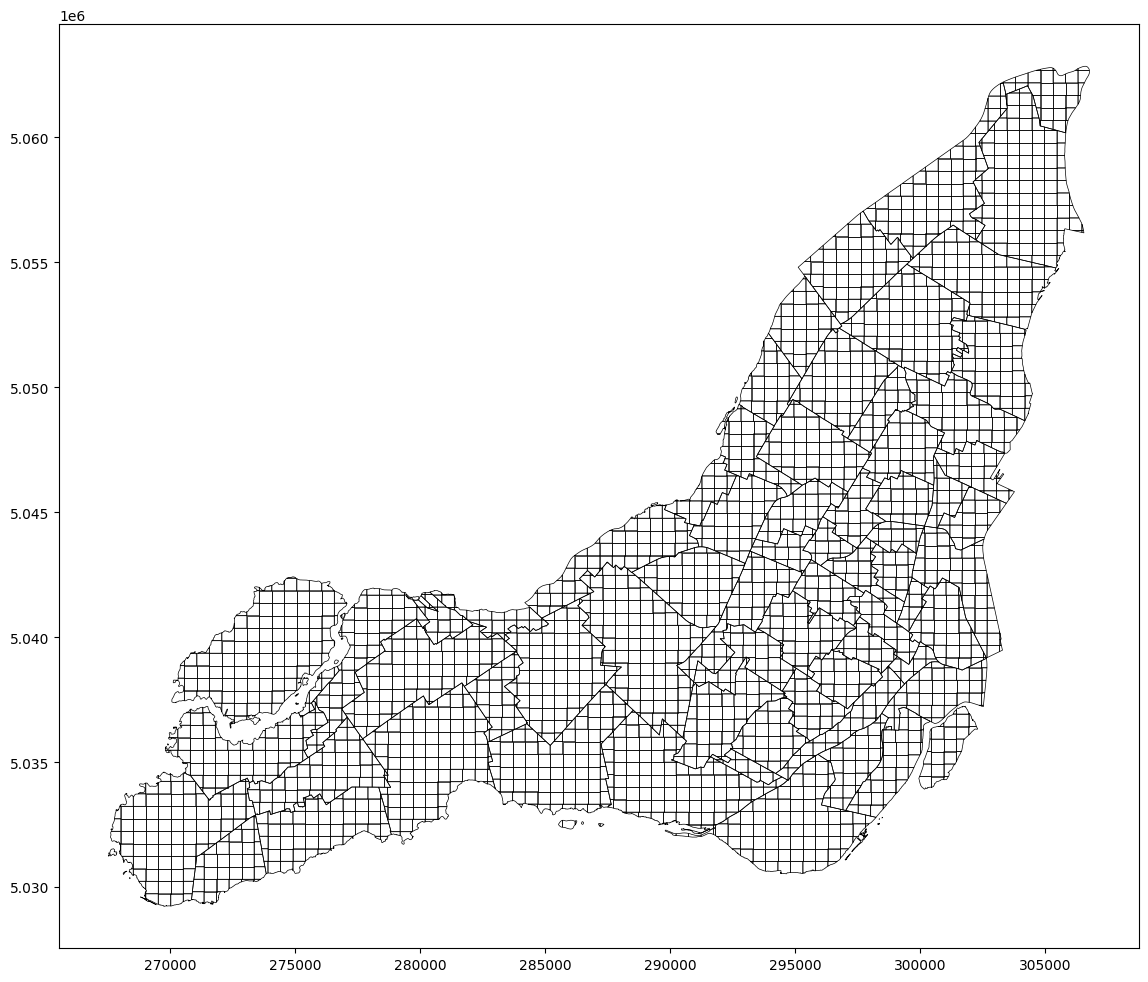

In [20]:
# @title
"""
fig, ax = plt.subplots(figsize=(15, 12))
all_grids_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

plt.show()

"""

In [ ]:
# @title
#all_grids_gdf.to_crs(epsg=4326)

In [25]:
uef_df_no_geometry.set_geometry(CENTROID, inplace=True)
uef_df_no_geometry.crs

In [ ]:
ter_admin_casernes.crs

In [28]:
ter_admin_casernes = ter_admin_casernes.to_crs(epsg=4326)
uef_df_no_geometry = uef_df_no_geometry.to_crs(epsg=4326)

In [29]:
# Perform a spatial join between uef_df_no_geometry and ter_admin_casernes
uef_casadminter_df = gpd.sjoin(uef_df_no_geometry, ter_admin_casernes, how="left", predicate="intersects")

In [32]:
uef_casadminter_df.columns

Index(['UEV_ID', 'CVC_START', 'STR_NAME', 'MUNI_CODE', 'MUNI_NAME', 'DIST_ID',
       'FLRS_AGND', 'NBR_UNITS', 'USE_CODE', 'USE_DES', 'USE_CAT', 'CONS_YEAR',
       'BLD_AGE', 'AGE_GR', 'BLD_AREA', 'centroid', 'index_right',
       'NOM_CAS_AD', 'NO_CAS_ADM', 'OBJECTID'],
      dtype='object')

In [53]:
uef_casadminter_df.NO_CAS_ADM.unique()

array([10., 57., 25.,  5., 33., 30., 76., 65., 66., 26., 29., 23., 21.,
       17., 78., 41., 16., 18., 39., 15., 64., 75., 20., 61., 32., 37.,
       19., 53., 27., 40., 47., 38., 67.,  3., 22., 63., 43.,  9., 46.,
       31., 44., 72., 48., 55., 74., 42., 56., 34., 14., 73., 28., 54.,
       49., 45., 35., 50., 71., 51., 13.,  4., 59., 58., 52.,  8., 62.,
       77., nan])

In [54]:
# Count null values per column
null_counts = uef_casadminter_df.isnull().sum()
null_counts


,0
UEV_ID,0
CVC_START,0
STR_NAME,0
MUNI_CODE,0
MUNI_NAME,0
DIST_ID,0
FLRS_AGND,0
NBR_UNITS,0
USE_CODE,0
USE_DES,0


In [55]:
# Filter the DataFrame to include only rows where 'NO_CAS_ADM' is NaN
nan_no_cas_adm_df = uef_casadminter_df[uef_casadminter_df['NO_CAS_ADM'].isna()]
nan_no_cas_adm_df.head()

# These four adresses are probably not covered by any caserne administrative area
# or at least the polygon was not precise enough to include them. Since they don't
# major impact on the model, I will just remove them.

,UEV_ID,CVC_START,STR_NAME,MUNI_CODE,MUNI_NAME,DIST_ID,FLRS_AGND,NBR_UNITS,USE_CODE,USE_DES,USE_CAT,CONS_YEAR,BLD_AGE,AGE_GR,BLD_AREA,centroid,index_right,NOM_CAS_AD,NO_CAS_ADM,OBJECTID
161127,04143320,20,avenue lilas,6,dorval,rem99,2,1,1000,logement,residential,1962,63,50-100,367.0,POINT (-73.73357 45.43783),NaN,NaN,NaN,NaN
233135,05061272,1800,chemin des iroquois,50,montréal,rem27,1,-1,6799,autres services gouvernementaux,public services,1969,56,50-100,864.0,POINT (-73.66922 45.43031),NaN,NaN,NaN,NaN
272456,05096233,275,boulevard gouin ouest,50,montréal,rem23,-1,-1,3280,atelier d'usinage,other,1930,95,50-100,87.0,POINT (-73.67933 45.54887),NaN,NaN,NaN,NaN
309265,04074248,63,rue gables,3,beaconsfield,rem99,2,1,1000,logement,residential,2014,11,<20,480.0,POINT (-73.85443 45.4258),NaN,NaN,NaN,NaN


In [57]:
uef_casadminter_df['geometry'] = uef_df['geometry']

In [58]:
uef_casadminter_df.columns

Index(['UEV_ID', 'CVC_START', 'STR_NAME', 'MUNI_CODE', 'MUNI_NAME', 'DIST_ID',
       'FLRS_AGND', 'NBR_UNITS', 'USE_CODE', 'USE_DES', 'USE_CAT', 'CONS_YEAR',
       'BLD_AGE', 'AGE_GR', 'BLD_AREA', 'centroid', 'index_right',
       'NOM_CAS_AD', 'NO_CAS_ADM', 'OBJECTID', 'geometry'],
      dtype='object')

In [59]:
uef_casadminter_df.MUNI_NAME.unique()

array(['montréal', 'westmount', 'côte-saint-luc', 'dollard-des ormeaux',
       'beaconsfield', 'dorval', 'pointe-claire', 'mont-royal',
       'kirkland', 'sainte-anne-de-bellevue', "baie-d'urfé", 'hampstead',
       'senneville', 'montréal-est', 'montréal-ouest', "l'île-dorval"],
      dtype=object)

In [46]:
hampstead_df = uef_casadminter_df[uef_casadminter_df['MUNI_NAME'] == 'hampstead']
hampstead_df.DIST_ID.unique()

array(['rem99'], dtype=object)

In [48]:
dorval_df = uef_casadminter_df[uef_casadminter_df['MUNI_NAME'] == 'dorval']
dorval_df.DIST_ID.unique()

array(['rem99'], dtype=object)

<Axes: >

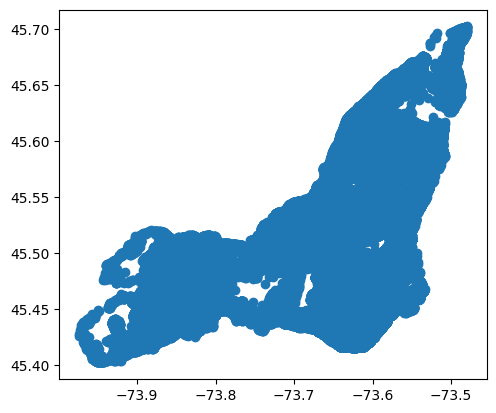

In [33]:
uef_casadminter_df.plot()

In [60]:
uef_casadminter_df.columns

Index(['UEV_ID', 'CVC_START', 'STR_NAME', 'MUNI_CODE', 'MUNI_NAME', 'DIST_ID',
       'FLRS_AGND', 'NBR_UNITS', 'USE_CODE', 'USE_DES', 'USE_CAT', 'CONS_YEAR',
       'BLD_AGE', 'AGE_GR', 'BLD_AREA', 'centroid', 'index_right',
       'NOM_CAS_AD', 'NO_CAS_ADM', 'OBJECTID', 'geometry'],
      dtype='object')

In [82]:
from re import M
# Group by 'NO_CAS_ADM' and aggregate specified columns
uef_casadminter_grouped_df = uef_casadminter_df.groupby('NO_CAS_ADM').agg(
    FLRS_AGND_mean=('FLRS_AGND', 'mean'),
    NBR_UNITS_mean=('NBR_UNITS', 'mean'),
    BLD_AGE_mean=('BLD_AGE', 'mean'),
    BLD_AREA_mean=('BLD_AREA', 'mean'),
    DIST_ID_first=('DIST_ID', 'first'),
    MUNI_NAME_first=('MUNI_NAME', 'first'),
    NOM_CAS_AD_first=('NOM_CAS_AD', 'first')  # Taking the first value for NOM_CAS_AD
).reset_index()

uef_casadminter_grouped_df = uef_casadminter_grouped_df[['NO_CAS_ADM', 'FLRS_AGND_mean',
                                                         'NBR_UNITS_mean', 'BLD_AGE_mean', 'BLD_AREA_mean',
                                                         'NOM_CAS_AD_first', 'DIST_ID_first', 'MUNI_NAME_first']]

uef_casadminter_grouped_df


,NO_CAS_ADM,FLRS_AGND_mean,NBR_UNITS_mean,BLD_AGE_mean,BLD_AREA_mean,NOM_CAS_AD_first,DIST_ID_first,MUNI_NAME_first
0,3.0,2.032907,7.036563,51.703839,1238.975564,Caserne 03,rem20,montréal
1,4.0,2.006400,4.401781,74.659432,574.285314,Caserne 04,rem34,montréal
2,5.0,2.448624,5.640367,100.706422,1520.875598,Caserne 05,rem19,montréal
3,8.0,1.494908,1.860489,68.866599,439.682292,Caserne 08,rem99,montréal-est
4,9.0,1.812053,2.796176,65.870975,321.451247,Caserne 09,rem25,montréal
...,...,...,...,...,...,...,...,...
61,74.0,1.866434,1.519491,72.732253,494.535457,Caserne 74,rem99,mont-royal
62,75.0,1.882981,2.229588,93.834705,350.839536,Caserne 75,rem05,montréal
63,76.0,2.021356,2.019034,104.568245,456.809446,Caserne 76,rem99,westmount
64,77.0,1.899540,1.271175,85.537098,245.570584,Caserne 77,rem99,montréal-ouest


In [83]:
# Merge the grouped_df with ter_admin_casernes on NO_CAS_ADM to get back the geometry column
# pa_fs_gdf = property assessment merged with fire stations geopandas
pa_fs_df = pd.merge(uef_casadminter_grouped_df, ter_admin_casernes, on='NO_CAS_ADM', how='left')

# Convert the merged DataFrame back to a GeoDataFrame
pa_fs_gdf = gpd.GeoDataFrame(pa_fs_df, geometry='geometry', crs=ter_admin_casernes.crs)

pa_fs_gdf.head()


,NO_CAS_ADM,FLRS_AGND_mean,NBR_UNITS_mean,BLD_AGE_mean,BLD_AREA_mean,NOM_CAS_AD_first,DIST_ID_first,MUNI_NAME_first,NOM_CAS_AD,OBJECTID,geometry
0,3.0,2.032907,7.036563,51.703839,1238.975564,Caserne 03,rem20,montréal,caserne 03,312,"POLYGON ((-73.55194 45.49108, -73.55177 45.490..."
1,4.0,2.006400,4.401781,74.659432,574.285314,Caserne 04,rem34,montréal,caserne 04,357,"POLYGON ((-73.66 45.50471, -73.65665 45.50376,..."
2,5.0,2.448624,5.640367,100.706422,1520.875598,Caserne 05,rem19,montréal,caserne 05,354,"POLYGON ((-73.56638 45.50302, -73.56733 45.501..."
3,8.0,1.494908,1.860489,68.866599,439.682292,Caserne 08,rem99,montréal-est,caserne 08,326,"POLYGON ((-73.49953 45.63412, -73.49951 45.634..."
4,9.0,1.812053,2.796176,65.870975,321.451247,Caserne 09,rem25,montréal,caserne 09,318,"POLYGON ((-73.61399 45.57979, -73.61235 45.579..."


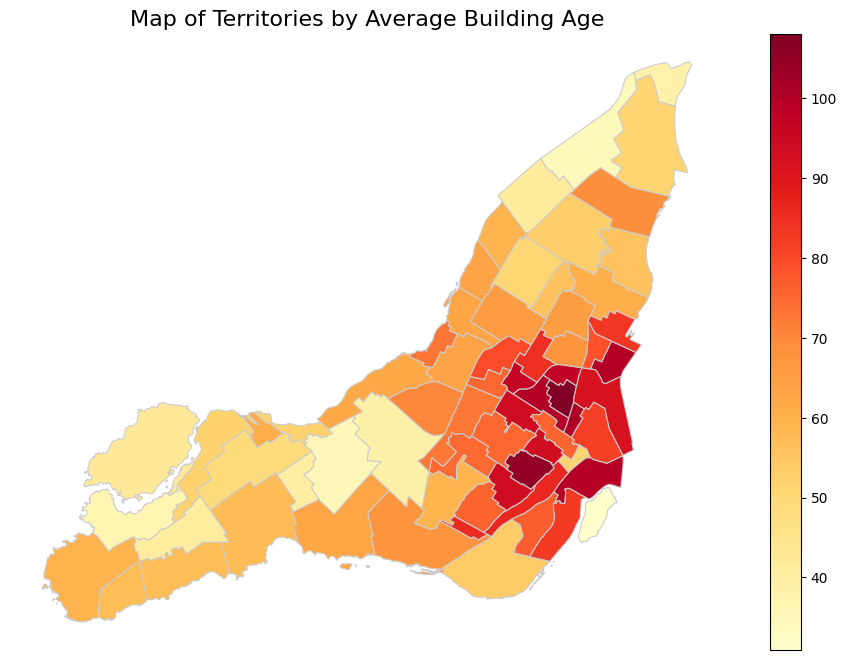

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the map, using BLD_AGE_mean for color with a different colormap
pa_fs_gdf.plot(column='BLD_AGE_mean', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.set_title('Map of Territories by Average Building Age', fontsize=16)
ax.set_axis_off()  # Turn off axis labels and ticks
plt.show()

In [85]:
pa_fs_gdf.columns

Index(['NO_CAS_ADM', 'FLRS_AGND_mean', 'NBR_UNITS_mean', 'BLD_AGE_mean',
       'BLD_AREA_mean', 'NOM_CAS_AD_first', 'DIST_ID_first', 'MUNI_NAME_first',
       'NOM_CAS_AD', 'OBJECTID', 'geometry'],
      dtype='object')

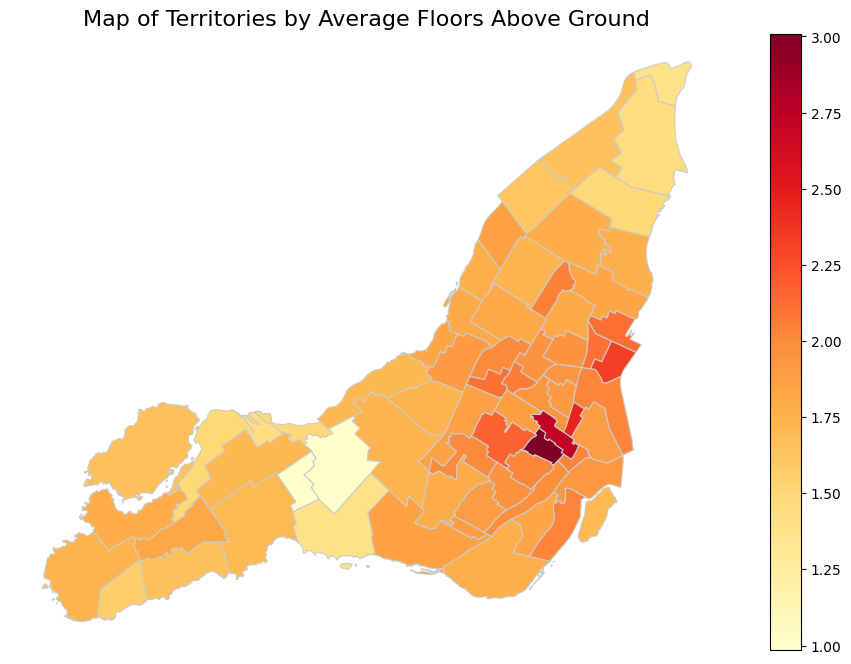

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the map, using FLRS_AGND_mean for color with a different colormap
pa_fs_gdf.plot(column='FLRS_AGND_mean', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.set_title('Map of Territories by Average Floors Above Ground', fontsize=16)
ax.set_axis_off()
plt.show()

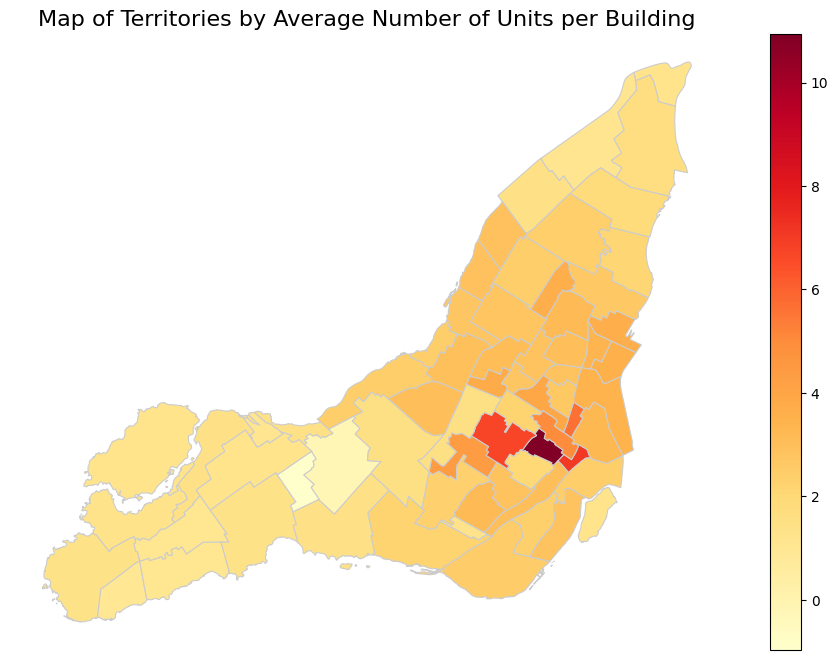

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the map, using NBR_UNITS_mean for color with a different colormap
pa_fs_gdf.plot(column='NBR_UNITS_mean', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.set_title('Map of Territories by Average Number of Units per Building', fontsize=16)
ax.set_axis_off()
plt.show()

In [49]:
list_admin_montreal = gpd.read_file(f"{Base_Path}/limites-administratives-agglomeration/limites-administratives-agglomeration-nad83.shp")

In [50]:
list_admin_montreal.columns

Index(['CODEID', 'NOM', 'NOM_OFFICI', 'CODEMAMH', 'CODE_3C', 'NUM', 'ABREV',
       'TYPE', 'COMMENT', 'DATEMODIF', 'geometry'],
      dtype='object')

In [76]:
# Lower case the dataframe
list_admin_montreal = lower_case_dataframe(list_admin_montreal)
list_admin_montreal.head()

,CODEID,NOM,NOM_OFFICI,CODEMAMH,CODE_3C,NUM,ABREV,TYPE,COMMENT,DATEMODIF,geometry
0,10,lasalle,lasalle,rem17,las,18,ls,arrondissement,None,2023-11-29,"POLYGON ((291800.968 5031331.566, 291809.951 5..."
1,3,dollard-des-ormeaux,dollard-des-ormeaux,66142,ddo,11,do,ville liée,None,2023-11-29,"POLYGON ((277698.951 5035907.484, 277544.162 5..."
2,27,côte-saint-luc,côte-saint-luc,66058,csl,72,cl,ville liée,None,2023-11-29,"MULTIPOLYGON (((290504.379 5035932.981, 290597..."
3,19,villeray-saint-michel-parc-extension,villeray–saint-michel–parc-extension,rem25,vse,26,vs,arrondissement,None,2023-11-29,"POLYGON ((295365.304 5042644.191, 295295.691 5..."
4,18,rosemont-la petite-patrie,rosemont–la petite-patrie,rem24,rpp,25,ro,arrondissement,None,2023-11-29,"POLYGON ((299454.771 5049061.793, 299698.469 5..."


In [77]:
list_admin_montreal.CODEMAMH.unique()

array(['rem17', '66142', '66058', 'rem25', 'rem24', '66062', '66127',
       'rem21', '66117', '66047', 'rem34', 'rem32', '66107', 'rem09',
       'rem12', 'rem20', 'rem22', '66007', 'rem27', 'rem14', 'rem16',
       'rem05', '66092', '66072', '66097', '66087', 'rem31', 'rem33',
       'rem23', 'rem15', 'rem19', '66102', '66112', '66032'], dtype=object)

In [78]:
list_admin_montreal.NOM.unique()

array(['lasalle', 'dollard-des-ormeaux', 'côte-saint-luc',
       'villeray-saint-michel-parc-extension',
       'rosemont-la petite-patrie', 'hampstead', 'senneville',
       'le plateau-mont-royal', 'sainte-anne-de-bellevue',
       'montréal-ouest', 'côte-des-neiges-notre-dame-de-grâce',
       "l'île-bizard-sainte-geneviève", 'beaconsfield', 'anjou', 'verdun',
       'le sud-ouest', 'mercier-hochelaga-maisonneuve', 'montréal-est',
       'lachine', 'saint-léonard', 'montréal-nord', 'outremont',
       "l'île-dorval", 'mont-royal', 'pointe-claire', 'dorval',
       'pierrefonds-roxboro', 'rivière-des-prairies-pointe-aux-trembles',
       'ahuntsic-cartierville', 'saint-laurent', 'ville-marie',
       'kirkland', "baie-d'urfé", 'westmount'], dtype=object)

In [87]:
pa_fs_gdf.MUNI_NAME_first.unique()

array(['montréal', 'montréal-est', 'sainte-anne-de-bellevue',
       "baie-d'urfé", 'beaconsfield', 'kirkland', 'pointe-claire',
       'dollard-des ormeaux', 'dorval', 'mont-royal', 'westmount',
       'montréal-ouest', 'côte-saint-luc'], dtype=object)

In [88]:
# Replace 'dollard-des ormeaux' with 'dollard-des-ormeaux' in the 'MUNI_NAME' column
pa_fs_gdf['MUNI_NAME_first'] = pa_fs_gdf['MUNI_NAME_first'].replace('dollard-des ormeaux', 'dollard-des-ormeaux')


In [89]:
pa_fs_gdf.MUNI_NAME_first.unique()

array(['montréal', 'montréal-est', 'sainte-anne-de-bellevue',
       "baie-d'urfé", 'beaconsfield', 'kirkland', 'pointe-claire',
       'dollard-des-ormeaux', 'dorval', 'mont-royal', 'westmount',
       'montréal-ouest', 'côte-saint-luc'], dtype=object)

In [90]:
district_mapping = dict(zip(list_admin_montreal['NOM'], list_admin_montreal['CODEMAMH']))

In [91]:
district_mapping

{'lasalle': 'rem17',
 'dollard-des-ormeaux': '66142',
 'côte-saint-luc': '66058',
 'villeray-saint-michel-parc-extension': 'rem25',
 'rosemont-la petite-patrie': 'rem24',
 'hampstead': '66062',
 'senneville': '66127',
 'le plateau-mont-royal': 'rem21',
 'sainte-anne-de-bellevue': '66117',
 'montréal-ouest': '66047',
 'côte-des-neiges-notre-dame-de-grâce': 'rem34',
 "l'île-bizard-sainte-geneviève": 'rem32',
 'beaconsfield': '66107',
 'anjou': 'rem09',
 'verdun': 'rem12',
 'le sud-ouest': 'rem20',
 'mercier-hochelaga-maisonneuve': 'rem22',
 'montréal-est': '66007',
 'lachine': 'rem27',
 'saint-léonard': 'rem14',
 'montréal-nord': 'rem16',
 'outremont': 'rem05',
 "l'île-dorval": '66092',
 'mont-royal': '66072',
 'pointe-claire': '66097',
 'dorval': '66087',
 'pierrefonds-roxboro': 'rem31',
 'rivière-des-prairies-pointe-aux-trembles': 'rem33',
 'ahuntsic-cartierville': 'rem23',
 'saint-laurent': 'rem15',
 'ville-marie': 'rem19',
 'kirkland': '66102',
 "baie-d'urfé": '66112',
 'westmount': 

In [ ]:
# Function to get the correct district ID or CODEMAMH
def get_correct_district_id(municipality_name):
  """
  Retrieves the correct district ID based on municipality name from the mapping.
  Returns the original ID if no mapping is found or the municipality name is invalid.
  """
  try:
    return district_mapping.get(municipality_name.lower(), None) # Handle case sensitivity
  except AttributeError:
      return None

# Apply the function to correct district IDs for rows where DIST_ID is 'rem99'
pa_fs_gdf.loc[pa_fs_gdf['DIST_ID_first'] == 'rem99', 'DIST_ID_first'] = \
    pa_fs_gdf.loc[pa_fs_gdf['DIST_ID_first'] == 'rem99', 'MUNI_NAME_first'].apply(get_correct_district_id)



In [97]:
pa_fs_gdf.DIST_ID_first.unique()

array(['rem20', 'rem34', 'rem19', '66007', 'rem25', 'rem22', 'rem33',
       'rem21', 'rem16', 'rem14', 'rem09', 'rem24', 'rem23', '66117',
       '66112', '66107', '66102', '66097', 'rem32', 'rem31', '66142',
       '66087', 'rem27', 'rem17', 'rem12', 'rem15', '66072', 'rem05',
       '66032', '66047', '66058'], dtype=object)

In [102]:
output_shp_path = f"{Base_Path}/propertyass_firestations/propertyass_firestations.shp"

pa_fs_gdf.to_file(output_shp_path, driver='ESRI Shapefile', encoding='utf-8')

<ipython-input-102-3b342a37e8e7>:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  pa_fs_gdf.to_file(output_shp_path, driver='ESRI Shapefile', encoding='utf-8')
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'FLRS_AGND_mean' to 'FLRS_AGND_'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'NBR_UNITS_mean' to 'NBR_UNITS_'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'BLD_AGE_mean' to 'BLD_AGE_me'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'BLD_AREA_mean' to 'BLD_AREA_m'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'NOM_CAS_AD_first' to 'NOM_CAS_AD'
  ogr_write(
/usr/local